In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_covtype
from sklearn.preprocessing import StandardScaler
import cupy as cp

In [11]:

# setting random seed
np.random.seed(123)

# generating the theta
theta = np.linspace(0, np.pi, 500)

# semicircle-1
s1_x = np.cos(theta) + np.random.normal(0, 0.1, size=theta.shape)
s1_y = np.sin(theta) + np.random.normal(0, 0.1, size=theta.shape)

# semicircle-2
s2_x = 1 + np.cos(theta) + np.random.normal(0, 0.1, size=theta.shape)
s2_y = -np.sin(theta) + np.random.normal(0, 0.1, size=theta.shape)

# combining data points
d1 = [(x, y) for x, y in zip(s1_x, s1_y)]
d2 = [(x, y) for x, y in zip(s2_x, s2_y)]
data_points = d1 + d2
data_points

[(np.float64(0.8914369396699439), np.float64(0.07520336682672812)),
 (np.float64(1.0997147263206788), np.float64(0.013259810218771439)),
 (np.float64(1.0282185772400134), np.float64(-0.013953341491120694)),
 (np.float64(0.8491921682822405), np.float64(0.11184465464680943)),
 (np.float64(0.9418228971106825), np.float64(0.15126257264281467)),
 (np.float64(1.1646482345432838), np.float64(0.16521906828270755)),
 (np.float64(0.756618697981703), np.float64(-0.06126179072717729)),
 (np.float64(0.9561377925233946), np.float64(-0.009388547019140978)),
 (np.float64(1.1253255161772238), np.float64(-0.11980468634974047)),
 (np.float64(0.911721098566111), np.float64(0.03277517513929419)),
 (np.float64(0.9301301990523698), np.float64(0.10452856755064874)),
 (np.float64(0.9881320345950988), np.float64(0.05591808400647662)),
 (np.float64(1.1462864697118962), np.float64(0.26856256073064566)),
 (np.float64(0.9327623594296575), np.float64(0.04116941740668614)),
 (np.float64(0.9517199111382401), np.float6

In [12]:
# Initial centroids from uniform sampling in the range [-2, 3] × [-2, 2]
C_1 = np.random.uniform([-2, -2], [3, 2])
C_2 = np.random.uniform([-2, -2], [3, 2])

max_iters = 10000
mappings = {}
current_iters = 0

for point in data_points:
    mappings[point] = np.random.randint(1, 3)

while current_iters < max_iters:
    num_points_updated = 0
    new_mappings = {}
    clusters = {1: [], 2: []}

    for point in data_points:
        d1 = np.linalg.norm(np.array(point) - C_1)
        d2 = np.linalg.norm(np.array(point) - C_2)
        new_cluster = 1 if d1 < d2 else 2
        if mappings[point] != new_cluster:
            num_points_updated += 1
        new_mappings[point] = new_cluster
        clusters[new_cluster].append(point)

    mappings = new_mappings

    if num_points_updated == 0:
        break

    # updating the centroids
    if clusters[1]:
        C_1 = np.mean(clusters[1], axis=0)
    if clusters[2]:
        C_2 = np.mean(clusters[2], axis=0)

    current_iters += 1

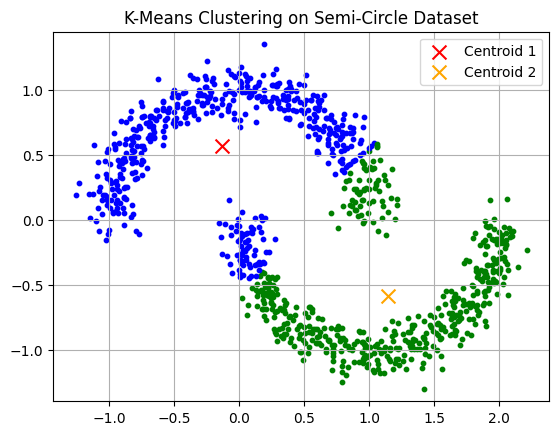

In [25]:
# plotting the data after classification
colors = {1: 'blue', 2: 'green'}
for point in data_points:
    plt.scatter(point[0], point[1], color=colors[mappings[point]], s=10)

plt.scatter(*C_1, color='red', marker='x', s=100, label='Centroid 1')
plt.scatter(*C_2, color='orange', marker='x', s=100, label='Centroid 2')
plt.title("K-Means Clustering on Semi-Circle Dataset")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Data preparation

In [14]:
# Load and subsample the dataset
cov_data = fetch_covtype()
X_full = cov_data.data

# Fix the seed and subsample 20,000 points
rng = np.random.default_rng(seed=42)
indices = rng.choice(X_full.shape[0], size=20000, replace=False)
X_sample = X_full[indices]

# Standardize quantitative features (first 10 columns), keep binary indicators
scaler = StandardScaler()
X_sample[:, :10] = scaler.fit_transform(X_sample[:, :10])

# Final data matrix
X = X_sample  # shape (20000, 54)

# Helper Functions

**K-means++**

In [15]:
def kmeans_plus_plus_init(X, k, rng=None):
    n_samples, _ = X.shape
    rng = rng or np.random.default_rng()

    # Step 1: randomly pick the first centroid
    centroids = []
    first_idx = rng.integers(n_samples)
    centroids.append(X[first_idx])

    for _ in range(1, k):
        # Compute squared distances to nearest centroid
        dist_sq = np.min([np.sum((X - c) ** 2, axis=1) for c in centroids], axis=0)

        # Sample next centroid with probability proportional to dist_sq
        probs = dist_sq / np.sum(dist_sq)
        next_idx = rng.choice(n_samples, p=probs)
        centroids.append(X[next_idx])

    return np.array(centroids)

**k-means: which can be used for both k-means++ and random initialization**

In [16]:
def run_kmeans(X, k, init='++', max_iters=500):
    if init == '++':
        centroids = kmeans_plus_plus_init(X, k)
    else:
        idx = np.random.choice(X.shape[0], size=k, replace=False)
        centroids = X[idx]

    for _ in range(max_iters):
        # assigning clusters
        dists = np.linalg.norm(X[:, None] - centroids[None, :], axis=2)
        labels = np.argmin(dists, axis=1)

        # updating centroids
        new_centroids = np.array([X[labels == j].mean(axis=0) if np.any(labels == j) else centroids[j] for j in range(k)])

        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids


    return centroids, labels

**WCSS**

In [17]:
# computing WCSS
def compute_wcss(X, centroids, labels):
    # calculating WCSS
    distances = np.linalg.norm(X[:, None] - centroids[None, :], axis=2)
    min_distances = np.min(distances ** 2, axis=1)  # square of distances to the nearest centroid
    wcss = np.sum(min_distances)
    return wcss

**Running k-means++ for k = 7**

In [22]:
# running K-Means with K-Means++ initialization
k = 7
centroids_pp, labels_pp = run_kmeans(X, k, init='++')
wc_ssd_pp = compute_wcss(X, centroids_pp, labels_pp)  # passing centroids and labels to compute_wcss

# running K-Means with random initialization
centroids_random, labels_random = run_kmeans(X, k, init='random')
wc_ssd_random = compute_wcss(X, centroids_random, labels_random)  # passing centroids and labels to compute_wcss

# printing the WCSS values and compare
print("WC-SSD with K-Means++ initialization:", wc_ssd_pp)
print("WC-SSD with random initialization:", wc_ssd_random)

# comparing the WC-SSD values
if wc_ssd_pp < wc_ssd_random:
    print("K-Means++ initialization resulted in a lower WC-SSD, indicating better clustering.")
else:
    print("Random initialization resulted in a lower WC-SSD, which is unexpected.")

WC-SSD with K-Means++ initialization: 128158.14805084617
WC-SSD with random initialization: 129188.02084773636
K-Means++ initialization resulted in a lower WC-SSD, indicating better clustering.


**Defining the arrays(matrices) to store values**

In [19]:
# Set random seed for reproducibility
rng = np.random.default_rng(seed=42)

# Store the WCSS results for each K and each initialization method
kmpp_wcss_results = np.zeros((20, 10))  # 20 K values, 10 runs
km_wcss_results = np.zeros((20, 10))

# Number of runs
num_runs = 10

# Evaluating the K-means++ and random initialized functions


In [20]:
# Loop over values of K from 1 to 20
for k_idx, k in enumerate(range(1, 21)):
    print(f"Running for k = {k}...")

    # Inner loop: 10 different runs per K
    for run in range(num_runs):
        # Subsample 20,000 points from the dataset
        indices = rng.choice(X_full.shape[0], size=20000, replace=False)
        X_sample = X_full[indices]

        # Standardize the first 10 quantitative columns (first 10 features)
        scaler = StandardScaler()
        X_sample[:, :10] = scaler.fit_transform(X_sample[:, :10])

        # Run K-Means++ initialization and get centroids and labels
        centroids_pp, labels_pp = run_kmeans(X_sample, k, init='++')
        # Calculate WCSS using the centroids and labels for K-Means++
        kmpp_wcss = compute_wcss(X_sample, centroids_pp, labels_pp)
        kmpp_wcss_results[k_idx, run] = kmpp_wcss

        # Run random initialization and get centroids and labels
        centroids_random, labels_random = run_kmeans(X_sample, k, init='random')
        # Calculate WCSS using the centroids and labels for random initialization
        km_wcss = compute_wcss(X_sample, centroids_random, labels_random)
        km_wcss_results[k_idx, run] = km_wcss

# Average WCSS for both K-Means++ and random initialization across all runs
kmpp_avg_wcss = kmpp_wcss_results.mean(axis=1)
km_avg_wcss = km_wcss_results.mean(axis=1)

Running for k = 1...
Running for k = 2...
Running for k = 3...
Running for k = 4...
Running for k = 5...
Running for k = 6...
Running for k = 7...
Running for k = 8...
Running for k = 9...
Running for k = 10...
Running for k = 11...
Running for k = 12...
Running for k = 13...
Running for k = 14...
Running for k = 15...
Running for k = 16...
Running for k = 17...
Running for k = 18...
Running for k = 19...
Running for k = 20...


# PLotting the WCSS(elblow method) values of K-means++ and random initialized values from k = 1 to 20

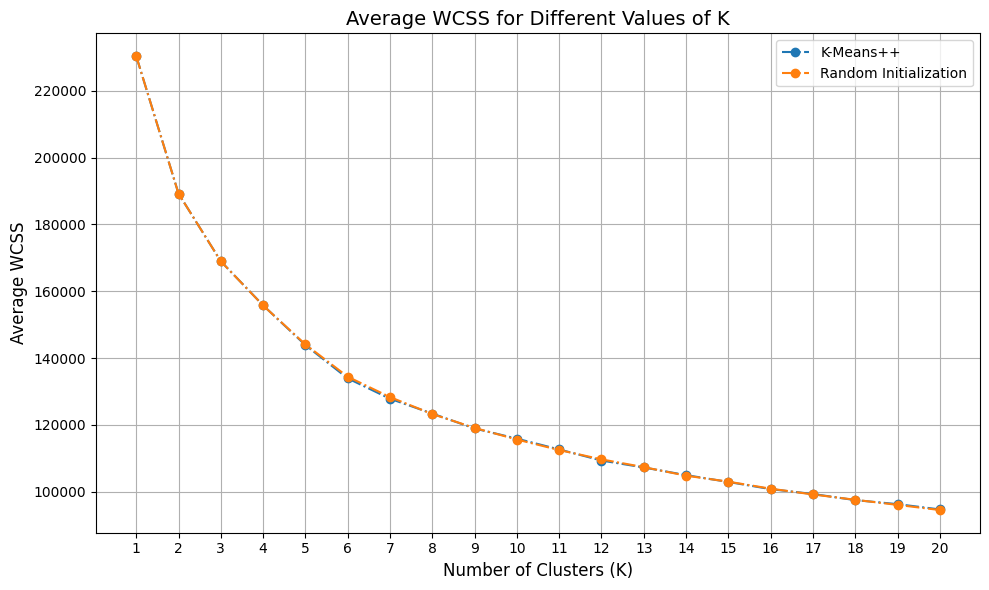

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), kmpp_avg_wcss, label='K-Means++', marker='o', linestyle='-.')
plt.plot(range(1, 21), km_avg_wcss, label='Random Initialization', marker='o', linestyle='-.')
plt.title("Average WCSS for Different Values of K", fontsize=14)
plt.xlabel("Number of Clusters (K)", fontsize=12)
plt.ylabel("Average WCSS", fontsize=12)
plt.xticks(range(1, 21))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()